# PRACTICE \#3: Vision Transformer (ViT)
## Course: Advanced Computer Vision

## Student

| ID | Name | Class |
| --- | --- | --- |
| 21127240 | Nguyễn Phát Đạt | HP2-K33|

## Instructors

* Ly Quoc Ngoc
* Nguyen Manh Hung

## Setup environment

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

## Construct model

### Attention module

In [2]:
class Attention(nn.Module):
    '''
    Attention Module is used to perform self-attention operation allowing the
    model to attend information from different representation subspaces on an input
    sequence of embeddings.
    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads
    Methods:
        forward(inp) :-
        Performs the self-attention operation on the input sequence embedding.
        Returns the output of self-attention can be seen as an attention map
        inp (batch_size, seq_len, embed_dim)
        out:(batch_size, seq_len, embed_dim),
    Examples:
        >>> attention = Attention(embed_dim, heads, activation, dropout)
        >>> out = attention(inp)
    '''

    def __init__(self, embed_dim, heads, attention_bias=False, dropout=0.1):
        super(Attention, self).__init__()

        self.embed_dim = embed_dim
        self.heads = heads

        self.head_dim = self.embed_dim // self.heads

        # query, key, value
        self.wq = nn.Linear(embed_dim, embed_dim, bias=attention_bias)  # Query
        self.wk = nn.Linear(embed_dim, embed_dim, bias=attention_bias)  # Key
        self.wv = nn.Linear(embed_dim, embed_dim, bias=attention_bias)  # Value

        self.atten_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)

        self.fc_out = nn.Linear(embed_dim, embed_dim)  # Output projection

    def forward(self, inp): # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        # Step 1: Linear projections
        queries = self.wq(inp)
        keys = self.wk(inp)
        values = self.wv(inp)

        # Step 2: Reshape and split into heads
        queries = queries.view(batch_size, seq_len, self.heads, self.head_dim)
        keys = keys.view(batch_size, seq_len, self.heads, self.head_dim)
        values = values.view(batch_size, seq_len, self.heads, self.head_dim)

        # permute axes to get: (batch_size, heads, seq_len, head_dim)
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        # Step 3: Compute attention
        attention_scores = torch.matmul(queries, keys.transpose(-1, -2)) / (self.head_dim ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)

        attention_weights = self.atten_dropout(attention_weights)

        context = torch.matmul(attention_weights, values)

        # Concatenate heads
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)

        # Step 4: Output projection
        out = self.fc_out(context)
        out = self.proj_dropout(out)
        return out


Example

In [3]:
batch_size = 32
seq_len = 10
embed_dim = 512
heads = 8

In [4]:
inp = torch.randn(batch_size, seq_len, embed_dim)  # Example input
attention = Attention(embed_dim, heads)
out = attention(inp)
print("input shape:", inp.shape)
print("output shape:", out.shape)

input shape: torch.Size([32, 10, 512])
output shape: torch.Size([32, 10, 512])


### TransformerBlock

In [5]:
class TransformerBlock(nn.Module):
    '''
    Transformer Block combines both the attention module and the feed-forward
    module with layer normalization, dropout and residual connections. The sequence
    of operations is as follows :-
    Inp -> LayerNorm1 -> Attention -> Residual -> LayerNorm2 -> FeedForward -> Out
    |                                   | |                                   |
    |-------------Addition--------------| |---------------Addition------------|
    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        mlp_dim: The higher dimension is used to transform the input embedding
        and then resized back to embedding dimension to capture richer information.
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)
    Examples:
        >> TB = TransformerBlock(embed_dim, mlp_dim, heads, activation, dropout)
        >> out = TB(inp)
    '''
    def __init__(self, embed_dim, mlp_dim, heads, attention_bias=False, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = Attention(embed_dim, heads, attention_bias, dropout)

        self.fc1 = nn.Linear(embed_dim, mlp_dim)
        self.fc2 = nn.Linear(mlp_dim, embed_dim)

        self.activation = nn.GELU()

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, inp): # inp: (batch_size, seq_len, embed_dim)
        # Step 1: Inp -> LayerNorm1 -> Attention -> Residual
        # |                                            |
        # |-------------Addition-----------------------|
        x = self.norm1(inp)
        x = self.attention(x)
        res = x + inp
        # Step 2: Residual -> LayerNorm2 -> FeedForward -> Out
        # |                                                 |
        # |-------------Addition----------------------------|
        x = self.norm2(res)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.dropout2(x)
        out = x + res
        return out

Example

In [6]:
mlp_dim = 128

In [7]:
transformerblock = TransformerBlock(embed_dim, mlp_dim, heads)
out = transformerblock(inp)
print("input shape:", inp.shape)
print("output shape:", out.shape)

input shape: torch.Size([32, 10, 512])
output shape: torch.Size([32, 10, 512])


### Transformer

In [8]:
class Transformer(nn.Module):
    '''
    Transformer combines multiple layers of Transformer Blocks in a sequential
    manner. The sequence
    of the operations is as follows -
    Input -> TB1 -> TB2 -> .......... -> TBn (n being the number of layers) -> Output
    Args:
        embed_dim: Dimension size of the hidden embedding in the TransfomerBlock
        mlp_dim: Dimension size of MLP layer in the TransfomerBlock
        layers: Number of Transformer Blocks in the Transformer
        heads: Number of parallel attention heads (Default=8)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        >>> out = transformer(inp)
    '''
    def __init__(self, layers, embed_dim, mlp_dim, heads=8, attention_bias=False, dropout=0.1):
        super(Transformer, self).__init__()

        self.trans_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, mlp_dim, heads, attention_bias, dropout) for i in range(layers)]
        )

    def forward(self, inp): # inp: (batch_size, seq_len, embed_dim)
        x = inp
        for layer in self.trans_blocks:
            x = layer(x)
        return x

Example

In [9]:
layers = 3
mlp_dim = 128

In [10]:
encoder = Transformer(layers, embed_dim, mlp_dim, heads)
out = encoder(inp)
print("input shape:", inp.shape)
print("output shape:", out.shape)

input shape: torch.Size([32, 10, 512])
output shape: torch.Size([32, 10, 512])


### ClassificationHead

In [11]:
class ClassificationHead(nn.Module):
    '''
    Classification Head attached to the first sequence token which is used as
    the arbitrary
    classification token and used to optimize the transformer model by applying
    Cross-Entropy
    loss. The sequence of operations is as follows :-
    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output
    Args:
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classification classes in the dataset
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, embed_dim) -> (batch_size, classes)
    Examples:
        >>> CH = ClassificationHead(embed_dim, classes, dropout)
        >>> out = CH(inp)
    '''
    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes

        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, inp): # inp: (batch_size, embed_dim)
        x = self.fc1(inp)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

Example

In [12]:
classes = 5
inp_cls = torch.randn(batch_size, embed_dim)

In [13]:
ch = ClassificationHead(embed_dim, classes, dropout=0.1)
out = ch(inp_cls)
print("input shape:", inp_cls.shape)
print("output shape:", out.shape)

input shape: torch.Size([32, 512])
output shape: torch.Size([32, 5])


### VisionTransformer

In [14]:
class VisionTransformer(nn.Module):
    '''
    Vision Transformer is the complete end-to-end model architecture that
    combines all the above modules in a sequential manner. The sequence of the
    operations is as follows -
    Input -> CreatePatches -> ClassToken, PatchToEmbed, Position Embed -> Transformer -> ClassificationHead -> Output
                                |             ||                |
                                |---Concat--- ||----Addition----|
    Args:
        patch_size: Length of square patch size
        max_len: Max length of learnable positional embedding
        embed_dim: Dimension size of the hidden embedding
        mlp_dim: Dimension size of MLP embedding
        classes: Number of classes in the dataset
        layers: Number of Transformer Blocks in the Transformer
        channels: Number of channels in the input (Default=3)
        heads: Number of parallel attention heads (Default=8)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        It outputs the classification output as well as the sequence output of
        the transformer
        (batch_size, channels, width, height) -> (batch_size, classes),
        (batch_size, seq_len+1, embed_dim)
    Examples:
        >>> ViT = VisionTransformer(inp_channels, patch_size, max_len, heads,
        classes, layers, embed_dim, mlp_dim, channels,dropout)
        >>> class_out, hidden_seq = ViT(inp)
    '''
    def __init__(self, inp_channels, patch_size, max_len, heads, classes,
        layers, embed_dim, mlp_dim, attention_bias=False, dropout=0.1):
        super(VisionTransformer, self).__init__()

        self.inp_channels = inp_channels
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        # Patch embedding
        self.proj = nn.Conv2d(inp_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

        # Class token and positional embedding
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.zeros(1, (max_len + 1), embed_dim)) # 1D pos encoding
        self.dropout = nn.Dropout(dropout)

        # init Transformer and ClassificationHead
        self.transformer = Transformer(layers, embed_dim, mlp_dim, heads, attention_bias, dropout)
        self.classification_head = ClassificationHead(embed_dim, classes, dropout)

    def forward(self, inp):  # inp: (batch_size, channels, width, height)
        batch_size = inp.size(0)

        # Step 1 + 2: Patch embedding
        patches = self.proj(inp)                                           # (batch_size, embed_dim, num_patches, num_patches)
        patches = patches.flatten(2)                                       # (batch_size, embed_dim, num_patches**2)
        patches = patches.transpose(1, 2)                                  # (batch_size, num_patches**2, embed_dim)

        # Step 3: Prepend a classification token to embedding vectors
        class_tokens = self.class_token.expand(batch_size, -1, -1)         # (batch_size, 1, embed_dim)
        x = torch.cat((class_tokens, patches), dim=1)                      # (batch_size, num_patches**2 + 1, embed_dim)

        # Step 4: Add positional embeddings to embedding vectors
        x = x + self.pos_embedding[:, :x.size(1), :]                       # (batch_size, num_patches**2 + 1, embed_dim)

        x = self.dropout(x)

        # Step 5: Pass the through a sequence of Transformer Blocks
        hidden_seq = self.transformer(x)

        # Step 6: Extract the classification token
        # from final output of the Transformer Blocks to
        # pass through a ClassificationHead
        class_out = self.classification_head(hidden_seq[:, 0])             # (batch_size, classes)

        return class_out, hidden_seq                                       # (batch_size, classes), (batch_size, num_patches**2 + 1, embed_dim)


Example

In [15]:
channels = 3
inp = torch.randn(8, 3, 32, 32)

classes = 10

patch_size = 16
max_len = 100
heads = 8
layers = 3
embed_dim = 64
mlp_dim = 128
dropout = 0.1

In [16]:
vit = VisionTransformer(channels, patch_size, max_len, heads, classes, layers, embed_dim, mlp_dim)
class_out, hidden_seq = vit(inp)
print("input shape:", inp.shape)
print("output shape:", (class_out.shape, hidden_seq.shape))

input shape: torch.Size([8, 3, 32, 32])
output shape: (torch.Size([8, 10]), torch.Size([8, 5, 64]))


## Load data

Here, we'll train a ViT model for image classification task on **CIFAR10** dataset (image below):

![CIFAR-10](https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png)


**Description:** The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are:
* 50000 training images
* 10000 test images.


In [17]:
batch_size = 128

In [18]:
# location_path = "/content/drive/MyDrive/Advanced Computer Vision/data"
location_path = "Advanced Computer Vision/data"


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root=location_path, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root=location_path, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

img_classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore data

#### Data shape

In [19]:
print(f'Training dataset size: {trainloader.dataset.data.shape}')
print(f'Test dataset size: {testloader.dataset.data.shape}')

Training dataset size: (50000, 32, 32, 3)
Test dataset size: (10000, 32, 32, 3)


### Examine some samples

In [20]:
df = pd.DataFrame({"img": pd.Series([img.flatten() for img in trainloader.dataset.data]),
                   "label": trainloader.dataset.targets})

In [21]:
img_size = trainloader.dataset.data.shape[1]
img_channels = trainloader.dataset.data.shape[-1]
print(f'Image size: {img_size}')
print(f'Channels: {img_channels}')

Image size: 32
Channels: 3


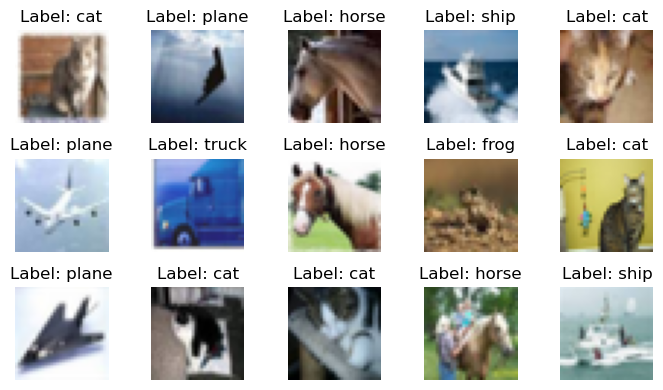

In [22]:
rows = 3
cols = 5

samples = df.sample(rows * cols)

fig, axes = plt.subplots(rows, cols, figsize=(7, 4), sharex=True, sharey=True)

for i in range(rows):
    for j in range(cols):
        sample = samples.iloc[i * cols + j]
        axes[i, j].imshow(sample['img'].reshape(img_size, img_size, img_channels))
        axes[i, j].set_title(f"Label: {img_classes[sample['label']]}")
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

## Hyperparameters

In [23]:
n_classes = len(img_classes)
patch_size = 16
max_len = (img_size // patch_size) ** 2 # img_size is 32

heads = 8
layers = 8
embed_dim = 128
mlp_dim = 256
attention_bias = False
dropout = 0.1

num_epochs = 100
learning_rate = 0.0001
weight_decay = 0.0001

## Initialize

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)
ViT = VisionTransformer(img_channels, patch_size, max_len,
                        heads, n_classes, layers, embed_dim, mlp_dim,
                        attention_bias, dropout).to(device)

Device:  cuda


In [25]:
ViT

VisionTransformer(
  (proj): Conv2d(3, 128, kernel_size=(16, 16), stride=(16, 16))
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (trans_blocks): ModuleList(
      (0-7): 8 x TransformerBlock(
        (attention): Attention(
          (wq): Linear(in_features=128, out_features=128, bias=False)
          (wk): Linear(in_features=128, out_features=128, bias=False)
          (wv): Linear(in_features=128, out_features=128, bias=False)
          (atten_dropout): Dropout(p=0.1, inplace=False)
          (proj_dropout): Dropout(p=0.1, inplace=False)
          (fc_out): Linear(in_features=128, out_features=128, bias=True)
        )
        (fc1): Linear(in_features=128, out_features=256, bias=True)
        (fc2): Linear(in_features=256, out_features=128, bias=True)
        (activation): GELU(approximate='none')
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (norm1): LayerNorm((128,), eps=1e-05, elementwis

## Loss and Optimizer

In [26]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(ViT.parameters(), lr=learning_rate, weight_decay=weight_decay)

## Training

In [27]:
# Training loop
def train(model, num_epochs, trainloader, testloader, optimizer, criterion, device):
    model.train()
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        total_train = 0

        for batch_idx, (data, targets) in enumerate(tqdm.tqdm(trainloader, desc=f"[Epoch: {epoch+1:4d} / {num_epochs:4d}]")):
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()

            output, _ = model(data)

            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted = output.max(1)

            total_train += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        train_acc = 100. * train_correct / total_train
        train_loss /= len(trainloader)
        train_losses.append(train_loss)

        # Evaluation on the test set
        model.eval()
        test_loss = 0
        test_correct = 0
        total_test = 0

        with torch.no_grad():
            for batch_idx, (data, targets) in enumerate(testloader):
                data, targets = data.to(device), targets.to(device)
                output, _ = model(data)
                loss = criterion(output, targets)

                test_loss += loss.item()
                _, predicted = output.max(1)
                total_test += targets.size(0)
                test_correct += predicted.eq(targets).sum().item()

        test_acc = 100. * test_correct / total_test
        test_loss /= len(testloader)
        test_losses.append(test_loss)

        print(f"\t[Train Loss: {train_loss:.4f}] [Train Acc: {train_acc:.2f}%] [Test Loss: {test_loss:.4f}] [Test Acc: {test_acc:.2f}%]\n")

    return train_losses, test_losses

In [28]:
train_losses, test_losses = train(ViT, num_epochs, trainloader, testloader, optimizer, criterion, device)

[Epoch:    1 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.52it/s]


	[Train Loss: 2.1611] [Train Acc: 29.62%] [Test Loss: 2.1048] [Test Acc: 34.80%]



[Epoch:    2 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.12it/s]


	[Train Loss: 2.1027] [Train Acc: 35.05%] [Test Loss: 2.0776] [Test Acc: 37.60%]



[Epoch:    3 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.09it/s]


	[Train Loss: 2.0831] [Train Acc: 37.11%] [Test Loss: 2.0864] [Test Acc: 36.26%]



[Epoch:    4 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.25it/s]


	[Train Loss: 2.0690] [Train Acc: 38.66%] [Test Loss: 2.0654] [Test Acc: 39.02%]



[Epoch:    5 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.51it/s]


	[Train Loss: 2.0588] [Train Acc: 39.59%] [Test Loss: 2.0509] [Test Acc: 40.45%]



[Epoch:    6 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.87it/s]


	[Train Loss: 2.0478] [Train Acc: 40.80%] [Test Loss: 2.0393] [Test Acc: 41.79%]



[Epoch:    7 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.12it/s]


	[Train Loss: 2.0359] [Train Acc: 41.93%] [Test Loss: 2.0329] [Test Acc: 42.49%]



[Epoch:    8 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 16.23it/s]


	[Train Loss: 2.0308] [Train Acc: 42.56%] [Test Loss: 2.0358] [Test Acc: 42.00%]



[Epoch:    9 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.33it/s]


	[Train Loss: 2.0223] [Train Acc: 43.45%] [Test Loss: 2.0272] [Test Acc: 43.00%]



[Epoch:   10 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.72it/s]


	[Train Loss: 2.0185] [Train Acc: 43.60%] [Test Loss: 2.0209] [Test Acc: 43.60%]



[Epoch:   11 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.00it/s]


	[Train Loss: 2.0129] [Train Acc: 44.38%] [Test Loss: 2.0219] [Test Acc: 43.26%]



[Epoch:   12 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.31it/s]


	[Train Loss: 2.0056] [Train Acc: 45.15%] [Test Loss: 2.0138] [Test Acc: 44.33%]



[Epoch:   13 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.63it/s]


	[Train Loss: 2.0010] [Train Acc: 45.73%] [Test Loss: 2.0064] [Test Acc: 45.10%]



[Epoch:   14 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.14it/s]


	[Train Loss: 1.9966] [Train Acc: 45.94%] [Test Loss: 2.0171] [Test Acc: 44.08%]



[Epoch:   15 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.39it/s]


	[Train Loss: 1.9901] [Train Acc: 46.77%] [Test Loss: 2.0014] [Test Acc: 45.72%]



[Epoch:   16 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.08it/s]


	[Train Loss: 1.9865] [Train Acc: 47.12%] [Test Loss: 1.9957] [Test Acc: 46.35%]



[Epoch:   17 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.13it/s]


	[Train Loss: 1.9802] [Train Acc: 47.67%] [Test Loss: 1.9982] [Test Acc: 45.89%]



[Epoch:   18 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.62it/s]


	[Train Loss: 1.9791] [Train Acc: 47.93%] [Test Loss: 1.9891] [Test Acc: 46.71%]



[Epoch:   19 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.23it/s]


	[Train Loss: 1.9723] [Train Acc: 48.63%] [Test Loss: 1.9939] [Test Acc: 46.37%]



[Epoch:   20 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.72it/s]


	[Train Loss: 1.9699] [Train Acc: 48.91%] [Test Loss: 1.9903] [Test Acc: 46.54%]



[Epoch:   21 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.72it/s]


	[Train Loss: 1.9674] [Train Acc: 49.08%] [Test Loss: 1.9871] [Test Acc: 46.87%]



[Epoch:   22 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.90it/s]


	[Train Loss: 1.9615] [Train Acc: 49.78%] [Test Loss: 1.9871] [Test Acc: 47.08%]



[Epoch:   23 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.56it/s]


	[Train Loss: 1.9598] [Train Acc: 49.81%] [Test Loss: 1.9857] [Test Acc: 47.07%]



[Epoch:   24 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.26it/s]


	[Train Loss: 1.9553] [Train Acc: 50.35%] [Test Loss: 1.9866] [Test Acc: 47.03%]



[Epoch:   25 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.39it/s]


	[Train Loss: 1.9522] [Train Acc: 50.54%] [Test Loss: 1.9773] [Test Acc: 48.02%]



[Epoch:   26 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 17.89it/s]


	[Train Loss: 1.9477] [Train Acc: 51.05%] [Test Loss: 1.9760] [Test Acc: 48.08%]



[Epoch:   27 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.04it/s]


	[Train Loss: 1.9466] [Train Acc: 51.14%] [Test Loss: 1.9824] [Test Acc: 47.39%]



[Epoch:   28 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.64it/s]


	[Train Loss: 1.9439] [Train Acc: 51.52%] [Test Loss: 1.9775] [Test Acc: 48.01%]



[Epoch:   29 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.96it/s]


	[Train Loss: 1.9428] [Train Acc: 51.55%] [Test Loss: 1.9701] [Test Acc: 48.77%]



[Epoch:   30 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.18it/s]


	[Train Loss: 1.9383] [Train Acc: 52.01%] [Test Loss: 1.9753] [Test Acc: 48.04%]



[Epoch:   31 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.34it/s]


	[Train Loss: 1.9335] [Train Acc: 52.52%] [Test Loss: 1.9697] [Test Acc: 48.81%]



[Epoch:   32 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.80it/s]


	[Train Loss: 1.9320] [Train Acc: 52.68%] [Test Loss: 1.9611] [Test Acc: 49.63%]



[Epoch:   33 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.43it/s]


	[Train Loss: 1.9301] [Train Acc: 52.88%] [Test Loss: 1.9727] [Test Acc: 48.30%]



[Epoch:   34 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.35it/s]


	[Train Loss: 1.9277] [Train Acc: 53.20%] [Test Loss: 1.9645] [Test Acc: 49.32%]



[Epoch:   35 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.93it/s]


	[Train Loss: 1.9237] [Train Acc: 53.48%] [Test Loss: 1.9635] [Test Acc: 49.44%]



[Epoch:   36 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.44it/s]


	[Train Loss: 1.9231] [Train Acc: 53.53%] [Test Loss: 1.9588] [Test Acc: 49.87%]



[Epoch:   37 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.18it/s]


	[Train Loss: 1.9210] [Train Acc: 53.76%] [Test Loss: 1.9614] [Test Acc: 49.80%]



[Epoch:   38 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.23it/s]


	[Train Loss: 1.9205] [Train Acc: 53.85%] [Test Loss: 1.9590] [Test Acc: 50.10%]



[Epoch:   39 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.05it/s]


	[Train Loss: 1.9143] [Train Acc: 54.45%] [Test Loss: 1.9573] [Test Acc: 50.08%]



[Epoch:   40 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 15.02it/s]


	[Train Loss: 1.9136] [Train Acc: 54.60%] [Test Loss: 1.9602] [Test Acc: 49.98%]



[Epoch:   41 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.98it/s]


	[Train Loss: 1.9127] [Train Acc: 54.63%] [Test Loss: 1.9617] [Test Acc: 49.61%]



[Epoch:   42 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.43it/s]


	[Train Loss: 1.9091] [Train Acc: 55.06%] [Test Loss: 1.9536] [Test Acc: 50.74%]



[Epoch:   43 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.67it/s]


	[Train Loss: 1.9083] [Train Acc: 55.09%] [Test Loss: 1.9579] [Test Acc: 49.95%]



[Epoch:   44 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.94it/s]


	[Train Loss: 1.9072] [Train Acc: 55.21%] [Test Loss: 1.9547] [Test Acc: 50.57%]



[Epoch:   45 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.29it/s]


	[Train Loss: 1.9049] [Train Acc: 55.40%] [Test Loss: 1.9496] [Test Acc: 51.06%]



[Epoch:   46 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.03it/s]


	[Train Loss: 1.9016] [Train Acc: 55.81%] [Test Loss: 1.9533] [Test Acc: 50.60%]



[Epoch:   47 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.76it/s]


	[Train Loss: 1.8980] [Train Acc: 56.13%] [Test Loss: 1.9517] [Test Acc: 50.76%]



[Epoch:   48 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.58it/s]


	[Train Loss: 1.8969] [Train Acc: 56.24%] [Test Loss: 1.9525] [Test Acc: 50.45%]



[Epoch:   49 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.29it/s]


	[Train Loss: 1.8953] [Train Acc: 56.39%] [Test Loss: 1.9510] [Test Acc: 50.58%]



[Epoch:   50 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.95it/s]


	[Train Loss: 1.8957] [Train Acc: 56.42%] [Test Loss: 1.9521] [Test Acc: 50.69%]



[Epoch:   51 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.79it/s]


	[Train Loss: 1.8937] [Train Acc: 56.59%] [Test Loss: 1.9475] [Test Acc: 51.03%]



[Epoch:   52 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.30it/s]


	[Train Loss: 1.8926] [Train Acc: 56.62%] [Test Loss: 1.9552] [Test Acc: 50.33%]



[Epoch:   53 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.12it/s]


	[Train Loss: 1.8860] [Train Acc: 57.35%] [Test Loss: 1.9433] [Test Acc: 51.65%]



[Epoch:   54 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.44it/s]


	[Train Loss: 1.8840] [Train Acc: 57.58%] [Test Loss: 1.9488] [Test Acc: 51.44%]



[Epoch:   55 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.86it/s]


	[Train Loss: 1.8849] [Train Acc: 57.52%] [Test Loss: 1.9443] [Test Acc: 51.36%]



[Epoch:   56 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.53it/s]


	[Train Loss: 1.8848] [Train Acc: 57.50%] [Test Loss: 1.9511] [Test Acc: 50.69%]



[Epoch:   57 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.97it/s]


	[Train Loss: 1.8828] [Train Acc: 57.65%] [Test Loss: 1.9455] [Test Acc: 51.33%]



[Epoch:   58 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.34it/s]


	[Train Loss: 1.8811] [Train Acc: 57.90%] [Test Loss: 1.9422] [Test Acc: 51.65%]



[Epoch:   59 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.43it/s]


	[Train Loss: 1.8784] [Train Acc: 58.11%] [Test Loss: 1.9484] [Test Acc: 51.19%]



[Epoch:   60 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 16.26it/s]


	[Train Loss: 1.8769] [Train Acc: 58.29%] [Test Loss: 1.9455] [Test Acc: 51.47%]



[Epoch:   61 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.37it/s]


	[Train Loss: 1.8765] [Train Acc: 58.31%] [Test Loss: 1.9417] [Test Acc: 51.67%]



[Epoch:   62 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.20it/s]


	[Train Loss: 1.8730] [Train Acc: 58.70%] [Test Loss: 1.9383] [Test Acc: 52.17%]



[Epoch:   63 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.21it/s]


	[Train Loss: 1.8719] [Train Acc: 58.84%] [Test Loss: 1.9442] [Test Acc: 51.52%]



[Epoch:   64 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.50it/s]


	[Train Loss: 1.8718] [Train Acc: 58.83%] [Test Loss: 1.9432] [Test Acc: 51.57%]



[Epoch:   65 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.00it/s]


	[Train Loss: 1.8704] [Train Acc: 58.86%] [Test Loss: 1.9390] [Test Acc: 52.03%]



[Epoch:   66 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.16it/s]


	[Train Loss: 1.8694] [Train Acc: 59.05%] [Test Loss: 1.9442] [Test Acc: 51.68%]



[Epoch:   67 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.81it/s]


	[Train Loss: 1.8671] [Train Acc: 59.23%] [Test Loss: 1.9452] [Test Acc: 51.43%]



[Epoch:   68 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.14it/s]


	[Train Loss: 1.8647] [Train Acc: 59.58%] [Test Loss: 1.9386] [Test Acc: 52.14%]



[Epoch:   69 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.49it/s]


	[Train Loss: 1.8627] [Train Acc: 59.74%] [Test Loss: 1.9376] [Test Acc: 52.22%]



[Epoch:   70 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.95it/s]


	[Train Loss: 1.8644] [Train Acc: 59.49%] [Test Loss: 1.9395] [Test Acc: 52.05%]



[Epoch:   71 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.39it/s]


	[Train Loss: 1.8612] [Train Acc: 59.94%] [Test Loss: 1.9430] [Test Acc: 51.63%]



[Epoch:   72 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.79it/s]


	[Train Loss: 1.8618] [Train Acc: 59.78%] [Test Loss: 1.9393] [Test Acc: 51.92%]



[Epoch:   73 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.70it/s]


	[Train Loss: 1.8567] [Train Acc: 60.37%] [Test Loss: 1.9343] [Test Acc: 52.50%]



[Epoch:   74 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.60it/s]


	[Train Loss: 1.8605] [Train Acc: 59.84%] [Test Loss: 1.9409] [Test Acc: 52.11%]



[Epoch:   75 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.02it/s]


	[Train Loss: 1.8568] [Train Acc: 60.35%] [Test Loss: 1.9419] [Test Acc: 51.75%]



[Epoch:   76 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 21.90it/s]


	[Train Loss: 1.8530] [Train Acc: 60.66%] [Test Loss: 1.9442] [Test Acc: 51.70%]



[Epoch:   77 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.04it/s]


	[Train Loss: 1.8536] [Train Acc: 60.61%] [Test Loss: 1.9354] [Test Acc: 52.38%]



[Epoch:   78 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.59it/s]


	[Train Loss: 1.8531] [Train Acc: 60.68%] [Test Loss: 1.9446] [Test Acc: 51.62%]



[Epoch:   79 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.63it/s]


	[Train Loss: 1.8499] [Train Acc: 61.02%] [Test Loss: 1.9343] [Test Acc: 52.60%]



[Epoch:   80 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.56it/s]


	[Train Loss: 1.8499] [Train Acc: 61.02%] [Test Loss: 1.9302] [Test Acc: 52.84%]



[Epoch:   81 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.15it/s]


	[Train Loss: 1.8480] [Train Acc: 61.26%] [Test Loss: 1.9300] [Test Acc: 53.26%]



[Epoch:   82 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.94it/s]


	[Train Loss: 1.8475] [Train Acc: 61.32%] [Test Loss: 1.9350] [Test Acc: 52.45%]



[Epoch:   83 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:35<00:00, 11.08it/s]


	[Train Loss: 1.8469] [Train Acc: 61.30%] [Test Loss: 1.9318] [Test Acc: 52.80%]



[Epoch:   84 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.59it/s]


	[Train Loss: 1.8463] [Train Acc: 61.40%] [Test Loss: 1.9334] [Test Acc: 52.67%]



[Epoch:   85 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.66it/s]


	[Train Loss: 1.8438] [Train Acc: 61.61%] [Test Loss: 1.9288] [Test Acc: 53.26%]



[Epoch:   86 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.59it/s]


	[Train Loss: 1.8411] [Train Acc: 61.88%] [Test Loss: 1.9300] [Test Acc: 53.13%]



[Epoch:   87 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.40it/s]


	[Train Loss: 1.8416] [Train Acc: 61.81%] [Test Loss: 1.9259] [Test Acc: 53.60%]



[Epoch:   88 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.25it/s]


	[Train Loss: 1.8395] [Train Acc: 61.99%] [Test Loss: 1.9279] [Test Acc: 53.34%]



[Epoch:   89 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.45it/s]


	[Train Loss: 1.8371] [Train Acc: 62.32%] [Test Loss: 1.9317] [Test Acc: 52.85%]



[Epoch:   90 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.15it/s]


	[Train Loss: 1.8363] [Train Acc: 62.39%] [Test Loss: 1.9277] [Test Acc: 53.15%]



[Epoch:   91 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.44it/s]


	[Train Loss: 1.8358] [Train Acc: 62.42%] [Test Loss: 1.9281] [Test Acc: 53.30%]



[Epoch:   92 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.28it/s]


	[Train Loss: 1.8359] [Train Acc: 62.48%] [Test Loss: 1.9230] [Test Acc: 53.73%]



[Epoch:   93 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.11it/s]


	[Train Loss: 1.8345] [Train Acc: 62.55%] [Test Loss: 1.9290] [Test Acc: 53.27%]



[Epoch:   94 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.14it/s]


	[Train Loss: 1.8337] [Train Acc: 62.63%] [Test Loss: 1.9278] [Test Acc: 53.41%]



[Epoch:   95 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.66it/s]


	[Train Loss: 1.8338] [Train Acc: 62.65%] [Test Loss: 1.9290] [Test Acc: 53.15%]



[Epoch:   96 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.43it/s]


	[Train Loss: 1.8326] [Train Acc: 62.70%] [Test Loss: 1.9252] [Test Acc: 53.55%]



[Epoch:   97 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.72it/s]


	[Train Loss: 1.8319] [Train Acc: 62.75%] [Test Loss: 1.9303] [Test Acc: 53.13%]



[Epoch:   98 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.11it/s]


	[Train Loss: 1.8305] [Train Acc: 62.95%] [Test Loss: 1.9304] [Test Acc: 53.03%]



[Epoch:   99 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.71it/s]


	[Train Loss: 1.8285] [Train Acc: 63.20%] [Test Loss: 1.9304] [Test Acc: 53.14%]



[Epoch:  100 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.42it/s]


	[Train Loss: 1.8283] [Train Acc: 63.25%] [Test Loss: 1.9339] [Test Acc: 52.59%]



### Training losses

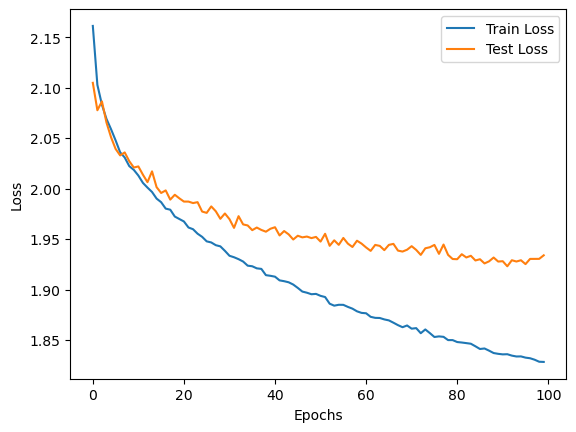

In [29]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Save model

In [30]:
vit_cp_path = "vit.pth"
torch.save(ViT.state_dict(), vit_cp_path)

## Load model

In [31]:
ViT = VisionTransformer(img_channels, patch_size, max_len, heads, n_classes, layers, embed_dim, mlp_dim, attention_bias, dropout).to(device)
ViT.load_state_dict(torch.load(vit_cp_path))
ViT.eval();

## Running inference

In [32]:
def infer(model, dataloader):
    model.eval()
    pred = []
    true = []
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(dataloader):
            data, targets = data.to(device), targets.to(device)
            output, _ = model(data)
            _, predicted = output.max(1)
            pred.extend(predicted.cpu().numpy())
            true.extend(targets.cpu().numpy())
    return np.array(pred), np.array(true)

In [33]:
pred, true = infer(ViT, testloader)

## Evaluation

### Accuracy

In [34]:
acc = accuracy_score(true, pred) * 100
print(f"Top-1 Accuracy on test set: {acc:.2f}%")

Top-1 Accuracy on test set: 52.59%


### Classification report

In [35]:
cr = classification_report(true, pred, target_names=img_classes)
print(cr)

              precision    recall  f1-score   support

       plane       0.65      0.49      0.56      1000
         car       0.63      0.64      0.64      1000
        bird       0.41      0.41      0.41      1000
         cat       0.36      0.25      0.30      1000
        deer       0.46      0.51      0.49      1000
         dog       0.44      0.48      0.46      1000
        frog       0.52      0.65      0.58      1000
       horse       0.64      0.53      0.58      1000
        ship       0.58      0.71      0.64      1000
       truck       0.55      0.59      0.57      1000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.52     10000
weighted avg       0.53      0.53      0.52     10000



### Confusion matrix

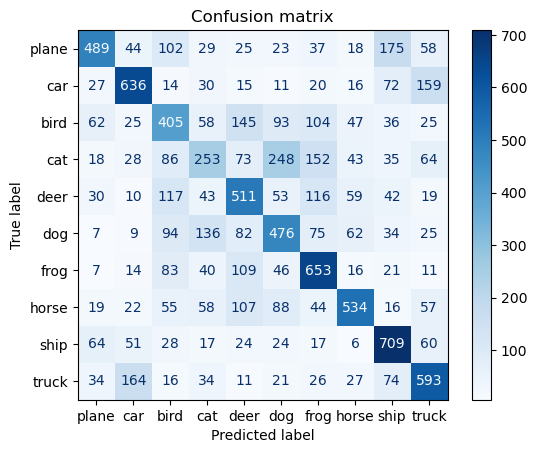

In [60]:
cm = confusion_matrix(true, pred)

fig, ax = plt.subplots(1, 1)
disp1 = ConfusionMatrixDisplay(cm, display_labels=img_classes)
disp1.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title('Confusion matrix')
plt.show()

## Configure hyperparameters

### Change patch size

Using a patch size of 16x16 (as in the original Vision Transformer paper) is unsuitable for the CIFAR-10 dataset, which contains images of size 32x32. This choice results in only $(32 / 16)^2 = 4$ patches per image, making each patch too large to describe the image effectively.

Instead, a patch size of 8x8 is more appropriate for CIFAR-10. This configuration yields $(32 / 8)^2 = 16$ patches per image, providing a finer granularity that better captures the local features and details within each image. This patch size strikes a balance between capturing enough detail and maintaining computational efficiency, making it a suitable choice for the relatively small 32x32 images in the CIFAR-10 dataset.

Note that a patch size of 4x4 is also a good choice but the computation cost will be much higher ("Transformer's sequence length is inversely proportional to the square of the patch size, thus models with smaller patch size are computationally more expensive", [Alexey Dosovitskiy et al.](https://arxiv.org/abs/2010.11929)).

In [37]:
new_patch_size = 8
new_max_len = (img_size // new_patch_size) ** 2

In [38]:
ViT_1 = VisionTransformer(img_channels, new_patch_size, new_max_len,
                          heads, n_classes, layers, embed_dim, mlp_dim,
                          attention_bias, dropout).to(device)
criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.Adam(ViT_1.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [39]:
train_losses_1, test_losses_1 = train(ViT_1, num_epochs, trainloader, testloader, optimizer_1, criterion_1, device)

[Epoch:    1 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.30it/s]


	[Train Loss: 2.1674] [Train Acc: 28.68%] [Test Loss: 2.1229] [Test Acc: 32.45%]



[Epoch:    2 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.85it/s]


	[Train Loss: 2.1077] [Train Acc: 34.52%] [Test Loss: 2.0781] [Test Acc: 37.87%]



[Epoch:    3 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.35it/s]


	[Train Loss: 2.0851] [Train Acc: 36.82%] [Test Loss: 2.0606] [Test Acc: 39.43%]



[Epoch:    4 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.05it/s]


	[Train Loss: 2.0696] [Train Acc: 38.56%] [Test Loss: 2.0526] [Test Acc: 40.18%]



[Epoch:    5 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.00it/s]


	[Train Loss: 2.0557] [Train Acc: 39.87%] [Test Loss: 2.0501] [Test Acc: 40.53%]



[Epoch:    6 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.44it/s]


	[Train Loss: 2.0415] [Train Acc: 41.35%] [Test Loss: 2.0272] [Test Acc: 42.84%]



[Epoch:    7 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.22it/s]


	[Train Loss: 2.0302] [Train Acc: 42.59%] [Test Loss: 2.0356] [Test Acc: 41.92%]



[Epoch:    8 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.97it/s]


	[Train Loss: 2.0173] [Train Acc: 43.91%] [Test Loss: 2.0239] [Test Acc: 42.93%]



[Epoch:    9 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.67it/s]


	[Train Loss: 2.0078] [Train Acc: 44.97%] [Test Loss: 2.0025] [Test Acc: 45.49%]



[Epoch:   10 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.86it/s]


	[Train Loss: 1.9962] [Train Acc: 46.01%] [Test Loss: 1.9967] [Test Acc: 46.08%]



[Epoch:   11 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.23it/s]


	[Train Loss: 1.9885] [Train Acc: 46.96%] [Test Loss: 1.9893] [Test Acc: 46.81%]



[Epoch:   12 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.64it/s]


	[Train Loss: 1.9833] [Train Acc: 47.40%] [Test Loss: 1.9856] [Test Acc: 47.08%]



[Epoch:   13 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.28it/s]


	[Train Loss: 1.9767] [Train Acc: 48.06%] [Test Loss: 1.9843] [Test Acc: 47.14%]



[Epoch:   14 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.86it/s]


	[Train Loss: 1.9693] [Train Acc: 48.87%] [Test Loss: 1.9690] [Test Acc: 48.80%]



[Epoch:   15 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.22it/s]


	[Train Loss: 1.9620] [Train Acc: 49.62%] [Test Loss: 1.9771] [Test Acc: 47.99%]



[Epoch:   16 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.12it/s]


	[Train Loss: 1.9576] [Train Acc: 50.00%] [Test Loss: 1.9645] [Test Acc: 49.35%]



[Epoch:   17 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.84it/s]


	[Train Loss: 1.9513] [Train Acc: 50.77%] [Test Loss: 1.9630] [Test Acc: 49.88%]



[Epoch:   18 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.39it/s]


	[Train Loss: 1.9501] [Train Acc: 50.75%] [Test Loss: 1.9516] [Test Acc: 50.93%]



[Epoch:   19 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.68it/s]


	[Train Loss: 1.9419] [Train Acc: 51.67%] [Test Loss: 1.9494] [Test Acc: 50.73%]



[Epoch:   20 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.94it/s]


	[Train Loss: 1.9408] [Train Acc: 51.73%] [Test Loss: 1.9543] [Test Acc: 50.60%]



[Epoch:   21 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.95it/s]


	[Train Loss: 1.9368] [Train Acc: 52.19%] [Test Loss: 1.9457] [Test Acc: 51.36%]



[Epoch:   22 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.81it/s]


	[Train Loss: 1.9312] [Train Acc: 52.75%] [Test Loss: 1.9486] [Test Acc: 50.82%]



[Epoch:   23 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.16it/s]


	[Train Loss: 1.9270] [Train Acc: 53.17%] [Test Loss: 1.9597] [Test Acc: 49.90%]



[Epoch:   24 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.43it/s]


	[Train Loss: 1.9224] [Train Acc: 53.70%] [Test Loss: 1.9480] [Test Acc: 51.17%]



[Epoch:   25 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.82it/s]


	[Train Loss: 1.9205] [Train Acc: 53.90%] [Test Loss: 1.9364] [Test Acc: 52.26%]



[Epoch:   26 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.58it/s]


	[Train Loss: 1.9195] [Train Acc: 53.87%] [Test Loss: 1.9388] [Test Acc: 51.98%]



[Epoch:   27 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.03it/s]


	[Train Loss: 1.9151] [Train Acc: 54.36%] [Test Loss: 1.9369] [Test Acc: 52.28%]



[Epoch:   28 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.31it/s]


	[Train Loss: 1.9118] [Train Acc: 54.66%] [Test Loss: 1.9358] [Test Acc: 52.23%]



[Epoch:   29 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.00it/s]


	[Train Loss: 1.9070] [Train Acc: 55.09%] [Test Loss: 1.9348] [Test Acc: 52.44%]



[Epoch:   30 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.92it/s]


	[Train Loss: 1.9042] [Train Acc: 55.48%] [Test Loss: 1.9370] [Test Acc: 52.23%]



[Epoch:   31 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 24.17it/s]


	[Train Loss: 1.9033] [Train Acc: 55.57%] [Test Loss: 1.9312] [Test Acc: 52.72%]



[Epoch:   32 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.72it/s]


	[Train Loss: 1.8989] [Train Acc: 55.96%] [Test Loss: 1.9310] [Test Acc: 52.86%]



[Epoch:   33 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.15it/s]


	[Train Loss: 1.8937] [Train Acc: 56.54%] [Test Loss: 1.9333] [Test Acc: 52.29%]



[Epoch:   34 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.37it/s]


	[Train Loss: 1.8915] [Train Acc: 56.76%] [Test Loss: 1.9224] [Test Acc: 53.88%]



[Epoch:   35 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.60it/s]


	[Train Loss: 1.8872] [Train Acc: 57.20%] [Test Loss: 1.9257] [Test Acc: 53.43%]



[Epoch:   36 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.58it/s]


	[Train Loss: 1.8898] [Train Acc: 56.98%] [Test Loss: 1.9354] [Test Acc: 52.25%]



[Epoch:   37 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 24.65it/s]


	[Train Loss: 1.8849] [Train Acc: 57.47%] [Test Loss: 1.9250] [Test Acc: 53.22%]



[Epoch:   38 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.19it/s]


	[Train Loss: 1.8821] [Train Acc: 57.74%] [Test Loss: 1.9182] [Test Acc: 54.08%]



[Epoch:   39 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.26it/s]


	[Train Loss: 1.8788] [Train Acc: 58.13%] [Test Loss: 1.9193] [Test Acc: 54.05%]



[Epoch:   40 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.33it/s]


	[Train Loss: 1.8790] [Train Acc: 58.06%] [Test Loss: 1.9109] [Test Acc: 54.92%]



[Epoch:   41 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.74it/s]


	[Train Loss: 1.8741] [Train Acc: 58.63%] [Test Loss: 1.9187] [Test Acc: 54.20%]



[Epoch:   42 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.55it/s]


	[Train Loss: 1.8723] [Train Acc: 58.70%] [Test Loss: 1.9227] [Test Acc: 53.49%]



[Epoch:   43 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.34it/s]


	[Train Loss: 1.8731] [Train Acc: 58.65%] [Test Loss: 1.9113] [Test Acc: 54.95%]



[Epoch:   44 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 17.87it/s]


	[Train Loss: 1.8673] [Train Acc: 59.19%] [Test Loss: 1.9136] [Test Acc: 54.68%]



[Epoch:   45 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.83it/s]


	[Train Loss: 1.8654] [Train Acc: 59.48%] [Test Loss: 1.9172] [Test Acc: 54.20%]



[Epoch:   46 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.58it/s]


	[Train Loss: 1.8622] [Train Acc: 59.73%] [Test Loss: 1.9094] [Test Acc: 55.24%]



[Epoch:   47 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.73it/s]


	[Train Loss: 1.8606] [Train Acc: 59.88%] [Test Loss: 1.9000] [Test Acc: 56.04%]



[Epoch:   48 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.11it/s]


	[Train Loss: 1.8621] [Train Acc: 59.57%] [Test Loss: 1.9156] [Test Acc: 54.35%]



[Epoch:   49 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.45it/s]


	[Train Loss: 1.8599] [Train Acc: 59.95%] [Test Loss: 1.9024] [Test Acc: 55.78%]



[Epoch:   50 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.42it/s]


	[Train Loss: 1.8548] [Train Acc: 60.49%] [Test Loss: 1.9032] [Test Acc: 55.52%]



[Epoch:   51 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.87it/s]


	[Train Loss: 1.8546] [Train Acc: 60.50%] [Test Loss: 1.8992] [Test Acc: 56.05%]



[Epoch:   52 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.09it/s]


	[Train Loss: 1.8518] [Train Acc: 60.76%] [Test Loss: 1.9111] [Test Acc: 54.87%]



[Epoch:   53 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.18it/s]


	[Train Loss: 1.8483] [Train Acc: 61.22%] [Test Loss: 1.8965] [Test Acc: 56.42%]



[Epoch:   54 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.97it/s]


	[Train Loss: 1.8461] [Train Acc: 61.39%] [Test Loss: 1.8993] [Test Acc: 56.25%]



[Epoch:   55 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.61it/s]


	[Train Loss: 1.8433] [Train Acc: 61.66%] [Test Loss: 1.9006] [Test Acc: 56.02%]



[Epoch:   56 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.31it/s]


	[Train Loss: 1.8424] [Train Acc: 61.76%] [Test Loss: 1.8998] [Test Acc: 56.22%]



[Epoch:   57 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.85it/s]


	[Train Loss: 1.8430] [Train Acc: 61.68%] [Test Loss: 1.9070] [Test Acc: 55.28%]



[Epoch:   58 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.41it/s]


	[Train Loss: 1.8417] [Train Acc: 61.78%] [Test Loss: 1.9036] [Test Acc: 55.49%]



[Epoch:   59 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.85it/s]


	[Train Loss: 1.8377] [Train Acc: 62.26%] [Test Loss: 1.8929] [Test Acc: 56.76%]



[Epoch:   60 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.17it/s]


	[Train Loss: 1.8357] [Train Acc: 62.44%] [Test Loss: 1.8912] [Test Acc: 56.92%]



[Epoch:   61 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.88it/s]


	[Train Loss: 1.8353] [Train Acc: 62.56%] [Test Loss: 1.8885] [Test Acc: 57.32%]



[Epoch:   62 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.24it/s]


	[Train Loss: 1.8344] [Train Acc: 62.56%] [Test Loss: 1.8902] [Test Acc: 57.27%]



[Epoch:   63 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.13it/s]


	[Train Loss: 1.8315] [Train Acc: 62.84%] [Test Loss: 1.8968] [Test Acc: 56.35%]



[Epoch:   64 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.74it/s]


	[Train Loss: 1.8310] [Train Acc: 62.88%] [Test Loss: 1.9018] [Test Acc: 55.93%]



[Epoch:   65 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.95it/s]


	[Train Loss: 1.8298] [Train Acc: 63.00%] [Test Loss: 1.8845] [Test Acc: 57.62%]



[Epoch:   66 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.77it/s]


	[Train Loss: 1.8303] [Train Acc: 62.93%] [Test Loss: 1.8893] [Test Acc: 57.00%]



[Epoch:   67 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.91it/s]


	[Train Loss: 1.8247] [Train Acc: 63.49%] [Test Loss: 1.8933] [Test Acc: 56.66%]



[Epoch:   68 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.46it/s]


	[Train Loss: 1.8268] [Train Acc: 63.26%] [Test Loss: 1.8943] [Test Acc: 56.59%]



[Epoch:   69 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.80it/s]


	[Train Loss: 1.8213] [Train Acc: 63.91%] [Test Loss: 1.8864] [Test Acc: 57.31%]



[Epoch:   70 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.48it/s]


	[Train Loss: 1.8220] [Train Acc: 63.78%] [Test Loss: 1.9020] [Test Acc: 55.77%]



[Epoch:   71 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.67it/s]


	[Train Loss: 1.8208] [Train Acc: 63.92%] [Test Loss: 1.8920] [Test Acc: 56.84%]



[Epoch:   72 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.36it/s]


	[Train Loss: 1.8183] [Train Acc: 64.28%] [Test Loss: 1.8903] [Test Acc: 57.02%]



[Epoch:   73 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.28it/s]


	[Train Loss: 1.8160] [Train Acc: 64.37%] [Test Loss: 1.8883] [Test Acc: 57.14%]



[Epoch:   74 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.65it/s]


	[Train Loss: 1.8153] [Train Acc: 64.47%] [Test Loss: 1.8858] [Test Acc: 57.47%]



[Epoch:   75 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.11it/s]


	[Train Loss: 1.8155] [Train Acc: 64.43%] [Test Loss: 1.8811] [Test Acc: 58.00%]



[Epoch:   76 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 17.00it/s]


	[Train Loss: 1.8133] [Train Acc: 64.64%] [Test Loss: 1.8878] [Test Acc: 57.49%]



[Epoch:   77 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.40it/s]


	[Train Loss: 1.8146] [Train Acc: 64.59%] [Test Loss: 1.8865] [Test Acc: 57.46%]



[Epoch:   78 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.50it/s]


	[Train Loss: 1.8114] [Train Acc: 64.86%] [Test Loss: 1.8840] [Test Acc: 57.60%]



[Epoch:   79 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.30it/s]


	[Train Loss: 1.8103] [Train Acc: 64.95%] [Test Loss: 1.8831] [Test Acc: 57.76%]



[Epoch:   80 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.52it/s]


	[Train Loss: 1.8074] [Train Acc: 65.31%] [Test Loss: 1.8888] [Test Acc: 57.15%]



[Epoch:   81 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.29it/s]


	[Train Loss: 1.8066] [Train Acc: 65.35%] [Test Loss: 1.8888] [Test Acc: 57.24%]



[Epoch:   82 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.36it/s]


	[Train Loss: 1.8045] [Train Acc: 65.63%] [Test Loss: 1.8830] [Test Acc: 57.80%]



[Epoch:   83 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.19it/s]


	[Train Loss: 1.8054] [Train Acc: 65.46%] [Test Loss: 1.8824] [Test Acc: 57.78%]



[Epoch:   84 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.49it/s]


	[Train Loss: 1.8049] [Train Acc: 65.46%] [Test Loss: 1.8815] [Test Acc: 57.91%]



[Epoch:   85 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.01it/s]


	[Train Loss: 1.8011] [Train Acc: 65.95%] [Test Loss: 1.8757] [Test Acc: 58.49%]



[Epoch:   86 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.49it/s]


	[Train Loss: 1.8021] [Train Acc: 65.78%] [Test Loss: 1.8834] [Test Acc: 57.71%]



[Epoch:   87 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.02it/s]


	[Train Loss: 1.8002] [Train Acc: 66.00%] [Test Loss: 1.8757] [Test Acc: 58.57%]



[Epoch:   88 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.53it/s]


	[Train Loss: 1.8004] [Train Acc: 65.98%] [Test Loss: 1.8815] [Test Acc: 58.03%]



[Epoch:   89 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.18it/s]


	[Train Loss: 1.7996] [Train Acc: 66.03%] [Test Loss: 1.8784] [Test Acc: 58.21%]



[Epoch:   90 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.15it/s]


	[Train Loss: 1.7964] [Train Acc: 66.30%] [Test Loss: 1.8794] [Test Acc: 58.06%]



[Epoch:   91 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.66it/s]


	[Train Loss: 1.7955] [Train Acc: 66.47%] [Test Loss: 1.8735] [Test Acc: 58.72%]



[Epoch:   92 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.73it/s]


	[Train Loss: 1.7913] [Train Acc: 66.93%] [Test Loss: 1.8818] [Test Acc: 57.95%]



[Epoch:   93 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.17it/s]


	[Train Loss: 1.7923] [Train Acc: 66.84%] [Test Loss: 1.8729] [Test Acc: 58.90%]



[Epoch:   94 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.32it/s]


	[Train Loss: 1.7931] [Train Acc: 66.74%] [Test Loss: 1.8757] [Test Acc: 58.53%]



[Epoch:   95 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.56it/s]


	[Train Loss: 1.7882] [Train Acc: 67.19%] [Test Loss: 1.8778] [Test Acc: 58.24%]



[Epoch:   96 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.76it/s]


	[Train Loss: 1.7920] [Train Acc: 66.83%] [Test Loss: 1.8708] [Test Acc: 58.93%]



[Epoch:   97 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.36it/s]


	[Train Loss: 1.7882] [Train Acc: 67.20%] [Test Loss: 1.8774] [Test Acc: 58.49%]



[Epoch:   98 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.13it/s]


	[Train Loss: 1.7892] [Train Acc: 67.16%] [Test Loss: 1.8802] [Test Acc: 57.95%]



[Epoch:   99 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.15it/s]


	[Train Loss: 1.7889] [Train Acc: 67.11%] [Test Loss: 1.8721] [Test Acc: 58.98%]



[Epoch:  100 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.49it/s]


	[Train Loss: 1.7863] [Train Acc: 67.45%] [Test Loss: 1.8703] [Test Acc: 59.08%]



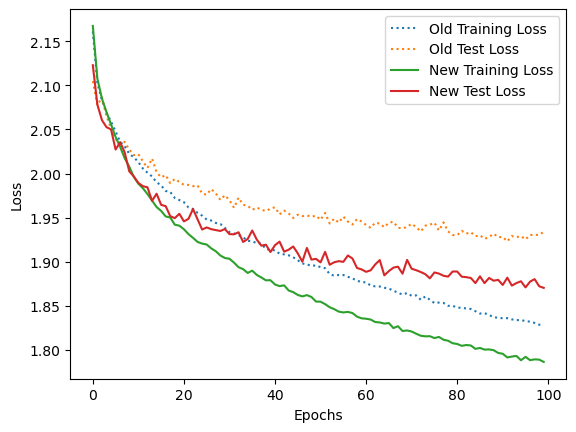

In [40]:
plt.plot(train_losses[:num_epochs], label='Old Training Loss', linestyle=':')
plt.plot(test_losses[:num_epochs], label='Old Test Loss', linestyle=':')
plt.plot(train_losses_1, label='New Training Loss')
plt.plot(test_losses_1, label='New Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

* We can see a huge improvement after choosing a suitable patch size, both training and testing losses have decreased significantly.

### Change number of heads and layers



In [41]:
new_layers = 12
new_heads = 16

In [42]:
ViT_2 = VisionTransformer(img_channels, new_patch_size, new_max_len,
                          new_heads, n_classes, new_layers, embed_dim, mlp_dim,
                          attention_bias, dropout).to(device)
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = torch.optim.Adam(ViT_2.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [43]:
train_losses_2, test_losses_2 = train(ViT_2, num_epochs, trainloader, testloader, optimizer_2, criterion_2, device)

[Epoch:    1 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.62it/s]


	[Train Loss: 2.1773] [Train Acc: 27.27%] [Test Loss: 2.1319] [Test Acc: 31.64%]



[Epoch:    2 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.21it/s]


	[Train Loss: 2.1165] [Train Acc: 33.63%] [Test Loss: 2.0899] [Test Acc: 36.08%]



[Epoch:    3 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.79it/s]


	[Train Loss: 2.0927] [Train Acc: 36.01%] [Test Loss: 2.0852] [Test Acc: 36.76%]



[Epoch:    4 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.44it/s]


	[Train Loss: 2.0767] [Train Acc: 37.74%] [Test Loss: 2.0638] [Test Acc: 39.34%]



[Epoch:    5 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.36it/s]


	[Train Loss: 2.0606] [Train Acc: 39.40%] [Test Loss: 2.0467] [Test Acc: 40.71%]



[Epoch:    6 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.27it/s]


	[Train Loss: 2.0481] [Train Acc: 40.66%] [Test Loss: 2.0404] [Test Acc: 41.86%]



[Epoch:    7 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.23it/s]


	[Train Loss: 2.0371] [Train Acc: 41.78%] [Test Loss: 2.0239] [Test Acc: 43.38%]



[Epoch:    8 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.13it/s]


	[Train Loss: 2.0250] [Train Acc: 43.06%] [Test Loss: 2.0226] [Test Acc: 43.35%]



[Epoch:    9 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.37it/s]


	[Train Loss: 2.0115] [Train Acc: 44.49%] [Test Loss: 2.0183] [Test Acc: 43.81%]



[Epoch:   10 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.27it/s]


	[Train Loss: 2.0059] [Train Acc: 45.08%] [Test Loss: 2.0192] [Test Acc: 43.51%]



[Epoch:   11 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.53it/s]


	[Train Loss: 1.9962] [Train Acc: 46.06%] [Test Loss: 2.0000] [Test Acc: 45.92%]



[Epoch:   12 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.87it/s]


	[Train Loss: 1.9879] [Train Acc: 46.91%] [Test Loss: 1.9766] [Test Acc: 48.38%]



[Epoch:   13 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.79it/s]


	[Train Loss: 1.9826] [Train Acc: 47.52%] [Test Loss: 1.9850] [Test Acc: 47.30%]



[Epoch:   14 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.69it/s]


	[Train Loss: 1.9752] [Train Acc: 48.18%] [Test Loss: 1.9842] [Test Acc: 47.45%]



[Epoch:   15 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.83it/s]


	[Train Loss: 1.9688] [Train Acc: 48.90%] [Test Loss: 1.9741] [Test Acc: 48.34%]



[Epoch:   16 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.91it/s]


	[Train Loss: 1.9624] [Train Acc: 49.57%] [Test Loss: 1.9663] [Test Acc: 49.08%]



[Epoch:   17 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:39<00:00,  9.94it/s]


	[Train Loss: 1.9543] [Train Acc: 50.38%] [Test Loss: 1.9652] [Test Acc: 49.32%]



[Epoch:   18 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.13it/s]


	[Train Loss: 1.9496] [Train Acc: 50.76%] [Test Loss: 1.9669] [Test Acc: 49.02%]



[Epoch:   19 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 11.87it/s]


	[Train Loss: 1.9447] [Train Acc: 51.43%] [Test Loss: 1.9498] [Test Acc: 51.24%]



[Epoch:   20 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.69it/s]


	[Train Loss: 1.9404] [Train Acc: 51.69%] [Test Loss: 1.9578] [Test Acc: 50.08%]



[Epoch:   21 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.09it/s]


	[Train Loss: 1.9381] [Train Acc: 51.99%] [Test Loss: 1.9578] [Test Acc: 50.11%]



[Epoch:   22 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.30it/s]


	[Train Loss: 1.9298] [Train Acc: 52.78%] [Test Loss: 1.9404] [Test Acc: 51.93%]



[Epoch:   23 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.60it/s]


	[Train Loss: 1.9226] [Train Acc: 53.66%] [Test Loss: 1.9345] [Test Acc: 52.67%]



[Epoch:   24 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.63it/s]


	[Train Loss: 1.9215] [Train Acc: 53.68%] [Test Loss: 1.9402] [Test Acc: 51.99%]



[Epoch:   25 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.29it/s]


	[Train Loss: 1.9187] [Train Acc: 54.06%] [Test Loss: 1.9377] [Test Acc: 52.18%]



[Epoch:   26 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.40it/s]


	[Train Loss: 1.9139] [Train Acc: 54.52%] [Test Loss: 1.9331] [Test Acc: 52.71%]



[Epoch:   27 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.55it/s]


	[Train Loss: 1.9076] [Train Acc: 55.19%] [Test Loss: 1.9296] [Test Acc: 52.97%]



[Epoch:   28 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.59it/s]


	[Train Loss: 1.9064] [Train Acc: 55.30%] [Test Loss: 1.9315] [Test Acc: 52.97%]



[Epoch:   29 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.83it/s]


	[Train Loss: 1.9049] [Train Acc: 55.40%] [Test Loss: 1.9273] [Test Acc: 53.28%]



[Epoch:   30 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.49it/s]


	[Train Loss: 1.9016] [Train Acc: 55.65%] [Test Loss: 1.9239] [Test Acc: 53.62%]



[Epoch:   31 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.88it/s]


	[Train Loss: 1.8948] [Train Acc: 56.47%] [Test Loss: 1.9369] [Test Acc: 52.09%]



[Epoch:   32 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.65it/s]


	[Train Loss: 1.8929] [Train Acc: 56.66%] [Test Loss: 1.9241] [Test Acc: 53.58%]



[Epoch:   33 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.09it/s]


	[Train Loss: 1.8919] [Train Acc: 56.66%] [Test Loss: 1.9275] [Test Acc: 53.20%]



[Epoch:   34 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.74it/s]


	[Train Loss: 1.8873] [Train Acc: 57.21%] [Test Loss: 1.9146] [Test Acc: 54.52%]



[Epoch:   35 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 13.00it/s]


	[Train Loss: 1.8853] [Train Acc: 57.39%] [Test Loss: 1.9142] [Test Acc: 54.58%]



[Epoch:   36 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.09it/s]


	[Train Loss: 1.8814] [Train Acc: 57.82%] [Test Loss: 1.9151] [Test Acc: 54.37%]



[Epoch:   37 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.65it/s]


	[Train Loss: 1.8791] [Train Acc: 58.04%] [Test Loss: 1.9174] [Test Acc: 54.12%]



[Epoch:   38 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.13it/s]


	[Train Loss: 1.8752] [Train Acc: 58.39%] [Test Loss: 1.9153] [Test Acc: 54.54%]



[Epoch:   39 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.46it/s]


	[Train Loss: 1.8730] [Train Acc: 58.69%] [Test Loss: 1.9095] [Test Acc: 54.99%]



[Epoch:   40 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.96it/s]


	[Train Loss: 1.8688] [Train Acc: 59.15%] [Test Loss: 1.9129] [Test Acc: 54.48%]



[Epoch:   41 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.87it/s]


	[Train Loss: 1.8684] [Train Acc: 59.14%] [Test Loss: 1.9139] [Test Acc: 54.50%]



[Epoch:   42 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.73it/s]


	[Train Loss: 1.8661] [Train Acc: 59.23%] [Test Loss: 1.9119] [Test Acc: 55.06%]



[Epoch:   43 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.10it/s]


	[Train Loss: 1.8625] [Train Acc: 59.76%] [Test Loss: 1.9091] [Test Acc: 55.04%]



[Epoch:   44 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.70it/s]


	[Train Loss: 1.8598] [Train Acc: 59.99%] [Test Loss: 1.9025] [Test Acc: 55.94%]



[Epoch:   45 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.08it/s]


	[Train Loss: 1.8605] [Train Acc: 59.90%] [Test Loss: 1.9033] [Test Acc: 55.71%]



[Epoch:   46 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.81it/s]


	[Train Loss: 1.8557] [Train Acc: 60.48%] [Test Loss: 1.9018] [Test Acc: 55.72%]



[Epoch:   47 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.72it/s]


	[Train Loss: 1.8555] [Train Acc: 60.31%] [Test Loss: 1.8986] [Test Acc: 56.10%]



[Epoch:   48 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.77it/s]


	[Train Loss: 1.8529] [Train Acc: 60.77%] [Test Loss: 1.8979] [Test Acc: 56.23%]



[Epoch:   49 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.66it/s]


	[Train Loss: 1.8493] [Train Acc: 61.03%] [Test Loss: 1.8991] [Test Acc: 56.20%]



[Epoch:   50 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.12it/s]


	[Train Loss: 1.8481] [Train Acc: 61.14%] [Test Loss: 1.9012] [Test Acc: 55.90%]



[Epoch:   51 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.72it/s]


	[Train Loss: 1.8478] [Train Acc: 61.23%] [Test Loss: 1.8944] [Test Acc: 56.72%]



[Epoch:   52 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.08it/s]


	[Train Loss: 1.8435] [Train Acc: 61.69%] [Test Loss: 1.8950] [Test Acc: 56.58%]



[Epoch:   53 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.14it/s]


	[Train Loss: 1.8406] [Train Acc: 61.94%] [Test Loss: 1.8914] [Test Acc: 57.02%]



[Epoch:   54 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.99it/s]


	[Train Loss: 1.8388] [Train Acc: 62.07%] [Test Loss: 1.8933] [Test Acc: 56.63%]



[Epoch:   55 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.06it/s]


	[Train Loss: 1.8390] [Train Acc: 62.05%] [Test Loss: 1.9024] [Test Acc: 55.65%]



[Epoch:   56 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.83it/s]


	[Train Loss: 1.8362] [Train Acc: 62.36%] [Test Loss: 1.8905] [Test Acc: 57.01%]



[Epoch:   57 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.31it/s]


	[Train Loss: 1.8340] [Train Acc: 62.67%] [Test Loss: 1.8897] [Test Acc: 57.04%]



[Epoch:   58 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.81it/s]


	[Train Loss: 1.8318] [Train Acc: 62.77%] [Test Loss: 1.8899] [Test Acc: 56.97%]



[Epoch:   59 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.76it/s]


	[Train Loss: 1.8307] [Train Acc: 63.00%] [Test Loss: 1.8906] [Test Acc: 56.93%]



[Epoch:   60 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 15.04it/s]


	[Train Loss: 1.8325] [Train Acc: 62.73%] [Test Loss: 1.8920] [Test Acc: 56.81%]



[Epoch:   61 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.32it/s]


	[Train Loss: 1.8275] [Train Acc: 63.25%] [Test Loss: 1.8867] [Test Acc: 57.44%]



[Epoch:   62 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.27it/s]


	[Train Loss: 1.8255] [Train Acc: 63.52%] [Test Loss: 1.8908] [Test Acc: 56.79%]



[Epoch:   63 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.27it/s]


	[Train Loss: 1.8257] [Train Acc: 63.40%] [Test Loss: 1.8881] [Test Acc: 56.95%]



[Epoch:   64 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.20it/s]


	[Train Loss: 1.8220] [Train Acc: 63.83%] [Test Loss: 1.8877] [Test Acc: 57.19%]



[Epoch:   65 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.50it/s]


	[Train Loss: 1.8224] [Train Acc: 63.69%] [Test Loss: 1.8797] [Test Acc: 58.02%]



[Epoch:   66 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.81it/s]


	[Train Loss: 1.8192] [Train Acc: 64.17%] [Test Loss: 1.8827] [Test Acc: 57.75%]



[Epoch:   67 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.17it/s]


	[Train Loss: 1.8204] [Train Acc: 63.92%] [Test Loss: 1.8871] [Test Acc: 57.28%]



[Epoch:   68 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.88it/s]


	[Train Loss: 1.8160] [Train Acc: 64.41%] [Test Loss: 1.8843] [Test Acc: 57.49%]



[Epoch:   69 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.13it/s]


	[Train Loss: 1.8154] [Train Acc: 64.47%] [Test Loss: 1.8886] [Test Acc: 56.93%]



[Epoch:   70 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.69it/s]


	[Train Loss: 1.8156] [Train Acc: 64.39%] [Test Loss: 1.8863] [Test Acc: 57.49%]



[Epoch:   71 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.93it/s]


	[Train Loss: 1.8128] [Train Acc: 64.77%] [Test Loss: 1.8836] [Test Acc: 57.80%]



[Epoch:   72 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.02it/s]


	[Train Loss: 1.8093] [Train Acc: 65.15%] [Test Loss: 1.8835] [Test Acc: 57.81%]



[Epoch:   73 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.73it/s]


	[Train Loss: 1.8067] [Train Acc: 65.37%] [Test Loss: 1.8795] [Test Acc: 58.07%]



[Epoch:   74 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.83it/s]


	[Train Loss: 1.8057] [Train Acc: 65.49%] [Test Loss: 1.8809] [Test Acc: 57.85%]



[Epoch:   75 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.76it/s]


	[Train Loss: 1.8059] [Train Acc: 65.41%] [Test Loss: 1.8832] [Test Acc: 57.80%]



[Epoch:   76 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.13it/s]


	[Train Loss: 1.8041] [Train Acc: 65.63%] [Test Loss: 1.8815] [Test Acc: 57.78%]



[Epoch:   77 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.19it/s]


	[Train Loss: 1.8026] [Train Acc: 65.74%] [Test Loss: 1.8785] [Test Acc: 58.21%]



[Epoch:   78 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.45it/s]


	[Train Loss: 1.8034] [Train Acc: 65.67%] [Test Loss: 1.8766] [Test Acc: 58.48%]



[Epoch:   79 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.36it/s]


	[Train Loss: 1.7996] [Train Acc: 66.11%] [Test Loss: 1.8747] [Test Acc: 58.54%]



[Epoch:   80 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.01it/s]


	[Train Loss: 1.7982] [Train Acc: 66.20%] [Test Loss: 1.8788] [Test Acc: 58.26%]



[Epoch:   81 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.84it/s]


	[Train Loss: 1.7979] [Train Acc: 66.29%] [Test Loss: 1.8746] [Test Acc: 58.76%]



[Epoch:   82 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.19it/s]


	[Train Loss: 1.7967] [Train Acc: 66.38%] [Test Loss: 1.8773] [Test Acc: 58.46%]



[Epoch:   83 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.19it/s]


	[Train Loss: 1.7941] [Train Acc: 66.61%] [Test Loss: 1.8759] [Test Acc: 58.47%]



[Epoch:   84 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.45it/s]


	[Train Loss: 1.7917] [Train Acc: 66.87%] [Test Loss: 1.8754] [Test Acc: 58.48%]



[Epoch:   85 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.12it/s]


	[Train Loss: 1.7931] [Train Acc: 66.63%] [Test Loss: 1.8734] [Test Acc: 58.73%]



[Epoch:   86 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.70it/s]


	[Train Loss: 1.7923] [Train Acc: 66.80%] [Test Loss: 1.8724] [Test Acc: 58.74%]



[Epoch:   87 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.47it/s]


	[Train Loss: 1.7913] [Train Acc: 66.83%] [Test Loss: 1.8683] [Test Acc: 59.28%]



[Epoch:   88 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.63it/s]


	[Train Loss: 1.7899] [Train Acc: 67.05%] [Test Loss: 1.8739] [Test Acc: 58.74%]



[Epoch:   89 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.49it/s]


	[Train Loss: 1.7898] [Train Acc: 66.99%] [Test Loss: 1.8730] [Test Acc: 58.77%]



[Epoch:   90 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.56it/s]


	[Train Loss: 1.7858] [Train Acc: 67.48%] [Test Loss: 1.8711] [Test Acc: 59.02%]



[Epoch:   91 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.25it/s]


	[Train Loss: 1.7853] [Train Acc: 67.58%] [Test Loss: 1.8758] [Test Acc: 58.35%]



[Epoch:   92 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.24it/s]


	[Train Loss: 1.7856] [Train Acc: 67.38%] [Test Loss: 1.8749] [Test Acc: 58.64%]



[Epoch:   93 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.43it/s]


	[Train Loss: 1.7819] [Train Acc: 67.83%] [Test Loss: 1.8754] [Test Acc: 58.57%]



[Epoch:   94 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.16it/s]


	[Train Loss: 1.7795] [Train Acc: 68.09%] [Test Loss: 1.8656] [Test Acc: 59.34%]



[Epoch:   95 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.01it/s]


	[Train Loss: 1.7837] [Train Acc: 67.68%] [Test Loss: 1.8773] [Test Acc: 58.33%]



[Epoch:   96 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.56it/s]


	[Train Loss: 1.7793] [Train Acc: 68.08%] [Test Loss: 1.8693] [Test Acc: 59.05%]



[Epoch:   97 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.95it/s]


	[Train Loss: 1.7800] [Train Acc: 68.03%] [Test Loss: 1.8697] [Test Acc: 59.14%]



[Epoch:   98 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.62it/s]


	[Train Loss: 1.7794] [Train Acc: 68.09%] [Test Loss: 1.8659] [Test Acc: 59.49%]



[Epoch:   99 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.87it/s]


	[Train Loss: 1.7766] [Train Acc: 68.41%] [Test Loss: 1.8643] [Test Acc: 59.58%]



[Epoch:  100 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.59it/s]


	[Train Loss: 1.7749] [Train Acc: 68.54%] [Test Loss: 1.8690] [Test Acc: 59.10%]



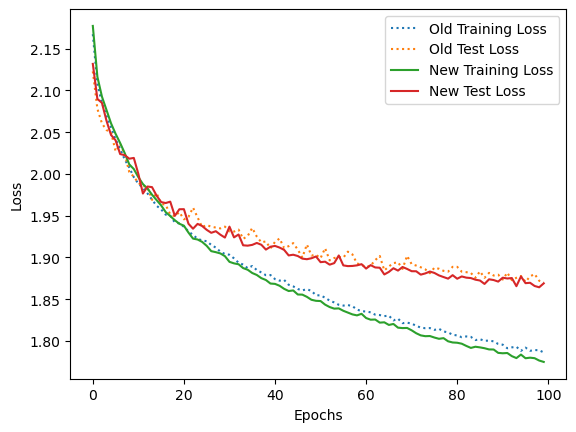

In [44]:
plt.plot(train_losses_1, label='Old Training Loss', linestyle=':')
plt.plot(test_losses_1, label='Old Test Loss', linestyle=':')
plt.plot(train_losses_2, label='New Training Loss')
plt.plot(test_losses_2, label='New Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

* No significant changes.

### Change feature size


In [45]:
new_embed_dim = 256
new_mlp_dim = 512

In [46]:
ViT_3 = VisionTransformer(img_channels, new_patch_size, new_max_len,
                          new_heads, n_classes, new_layers, new_embed_dim, new_mlp_dim,
                          attention_bias, dropout).to(device)
criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = torch.optim.Adam(ViT_3.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [47]:
train_losses_3, test_losses_3 = train(ViT_3, num_epochs, trainloader, testloader, optimizer_3, criterion_3, device)

[Epoch:    1 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.29it/s]


	[Train Loss: 2.1568] [Train Acc: 29.33%] [Test Loss: 2.1057] [Test Acc: 34.80%]



[Epoch:    2 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.51it/s]


	[Train Loss: 2.1019] [Train Acc: 35.04%] [Test Loss: 2.0815] [Test Acc: 37.03%]



[Epoch:    3 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.52it/s]


	[Train Loss: 2.0789] [Train Acc: 37.37%] [Test Loss: 2.0535] [Test Acc: 40.10%]



[Epoch:    4 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.52it/s]


	[Train Loss: 2.0574] [Train Acc: 39.78%] [Test Loss: 2.0401] [Test Acc: 41.23%]



[Epoch:    5 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.51it/s]


	[Train Loss: 2.0419] [Train Acc: 41.32%] [Test Loss: 2.0419] [Test Acc: 41.24%]



[Epoch:    6 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.52it/s]


	[Train Loss: 2.0211] [Train Acc: 43.43%] [Test Loss: 2.0257] [Test Acc: 43.30%]



[Epoch:    7 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.54it/s]


	[Train Loss: 2.0098] [Train Acc: 44.71%] [Test Loss: 2.0175] [Test Acc: 43.82%]



[Epoch:    8 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.49it/s]


	[Train Loss: 1.9924] [Train Acc: 46.46%] [Test Loss: 1.9903] [Test Acc: 46.52%]



[Epoch:    9 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.53it/s]


	[Train Loss: 1.9807] [Train Acc: 47.66%] [Test Loss: 1.9780] [Test Acc: 47.87%]



[Epoch:   10 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.50it/s]


	[Train Loss: 1.9672] [Train Acc: 48.99%] [Test Loss: 1.9717] [Test Acc: 48.49%]



[Epoch:   11 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.54it/s]


	[Train Loss: 1.9568] [Train Acc: 50.18%] [Test Loss: 1.9796] [Test Acc: 47.59%]



[Epoch:   12 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.52it/s]


	[Train Loss: 1.9469] [Train Acc: 51.09%] [Test Loss: 1.9614] [Test Acc: 49.40%]



[Epoch:   13 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.53it/s]


	[Train Loss: 1.9418] [Train Acc: 51.62%] [Test Loss: 1.9545] [Test Acc: 50.08%]



[Epoch:   14 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.55it/s]


	[Train Loss: 1.9308] [Train Acc: 52.78%] [Test Loss: 1.9485] [Test Acc: 51.07%]



[Epoch:   15 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.56it/s]


	[Train Loss: 1.9227] [Train Acc: 53.60%] [Test Loss: 1.9641] [Test Acc: 49.36%]



[Epoch:   16 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.53it/s]


	[Train Loss: 1.9194] [Train Acc: 53.90%] [Test Loss: 1.9463] [Test Acc: 51.25%]



[Epoch:   17 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.56it/s]


	[Train Loss: 1.9109] [Train Acc: 54.78%] [Test Loss: 1.9415] [Test Acc: 51.73%]



[Epoch:   18 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.58it/s]


	[Train Loss: 1.9029] [Train Acc: 55.63%] [Test Loss: 1.9297] [Test Acc: 52.93%]



[Epoch:   19 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.57it/s]


	[Train Loss: 1.9014] [Train Acc: 55.74%] [Test Loss: 1.9313] [Test Acc: 52.79%]



[Epoch:   20 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.57it/s]


	[Train Loss: 1.8910] [Train Acc: 56.89%] [Test Loss: 1.9257] [Test Acc: 53.45%]



[Epoch:   21 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.58it/s]


	[Train Loss: 1.8897] [Train Acc: 56.91%] [Test Loss: 1.9244] [Test Acc: 53.16%]



[Epoch:   22 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.58it/s]


	[Train Loss: 1.8814] [Train Acc: 57.88%] [Test Loss: 1.9344] [Test Acc: 52.33%]



[Epoch:   23 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.59it/s]


	[Train Loss: 1.8783] [Train Acc: 58.11%] [Test Loss: 1.9249] [Test Acc: 53.32%]



[Epoch:   24 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.58it/s]


	[Train Loss: 1.8712] [Train Acc: 58.83%] [Test Loss: 1.9225] [Test Acc: 53.70%]



[Epoch:   25 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.58it/s]


	[Train Loss: 1.8689] [Train Acc: 59.07%] [Test Loss: 1.9157] [Test Acc: 54.25%]



[Epoch:   26 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.59it/s]


	[Train Loss: 1.8619] [Train Acc: 59.80%] [Test Loss: 1.9221] [Test Acc: 53.75%]



[Epoch:   27 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.59it/s]


	[Train Loss: 1.8585] [Train Acc: 60.07%] [Test Loss: 1.9178] [Test Acc: 54.01%]



[Epoch:   28 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.58it/s]


	[Train Loss: 1.8545] [Train Acc: 60.56%] [Test Loss: 1.9166] [Test Acc: 54.17%]



[Epoch:   29 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.60it/s]


	[Train Loss: 1.8546] [Train Acc: 60.56%] [Test Loss: 1.9149] [Test Acc: 54.48%]



[Epoch:   30 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.56it/s]


	[Train Loss: 1.8484] [Train Acc: 61.12%] [Test Loss: 1.9067] [Test Acc: 55.51%]



[Epoch:   31 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.57it/s]


	[Train Loss: 1.8422] [Train Acc: 61.76%] [Test Loss: 1.9120] [Test Acc: 54.82%]



[Epoch:   32 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.60it/s]


	[Train Loss: 1.8396] [Train Acc: 62.05%] [Test Loss: 1.9143] [Test Acc: 54.36%]



[Epoch:   33 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.60it/s]


	[Train Loss: 1.8399] [Train Acc: 61.99%] [Test Loss: 1.9063] [Test Acc: 55.32%]



[Epoch:   34 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.61it/s]


	[Train Loss: 1.8328] [Train Acc: 62.70%] [Test Loss: 1.9004] [Test Acc: 55.88%]



[Epoch:   35 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.60it/s]


	[Train Loss: 1.8300] [Train Acc: 62.90%] [Test Loss: 1.9045] [Test Acc: 55.51%]



[Epoch:   36 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.61it/s]


	[Train Loss: 1.8258] [Train Acc: 63.48%] [Test Loss: 1.8977] [Test Acc: 55.85%]



[Epoch:   37 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.60it/s]


	[Train Loss: 1.8219] [Train Acc: 63.87%] [Test Loss: 1.8951] [Test Acc: 56.39%]



[Epoch:   38 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.60it/s]


	[Train Loss: 1.8213] [Train Acc: 63.84%] [Test Loss: 1.8973] [Test Acc: 56.06%]



[Epoch:   39 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.33it/s]


	[Train Loss: 1.8156] [Train Acc: 64.39%] [Test Loss: 1.8972] [Test Acc: 56.38%]



[Epoch:   40 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.43it/s]


	[Train Loss: 1.8122] [Train Acc: 64.78%] [Test Loss: 1.9007] [Test Acc: 56.05%]



[Epoch:   41 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.52it/s]


	[Train Loss: 1.8121] [Train Acc: 64.81%] [Test Loss: 1.8959] [Test Acc: 56.46%]



[Epoch:   42 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.48it/s]


	[Train Loss: 1.8087] [Train Acc: 65.09%] [Test Loss: 1.9023] [Test Acc: 55.68%]



[Epoch:   43 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.44it/s]


	[Train Loss: 1.8068] [Train Acc: 65.31%] [Test Loss: 1.8883] [Test Acc: 57.32%]



[Epoch:   44 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.41it/s]


	[Train Loss: 1.8018] [Train Acc: 65.93%] [Test Loss: 1.8894] [Test Acc: 57.23%]



[Epoch:   45 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.41it/s]


	[Train Loss: 1.7993] [Train Acc: 66.09%] [Test Loss: 1.8947] [Test Acc: 56.59%]



[Epoch:   46 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.41it/s]


	[Train Loss: 1.7968] [Train Acc: 66.36%] [Test Loss: 1.8931] [Test Acc: 56.77%]



[Epoch:   47 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.17it/s]


	[Train Loss: 1.7949] [Train Acc: 66.58%] [Test Loss: 1.8945] [Test Acc: 56.53%]



[Epoch:   48 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.33it/s]


	[Train Loss: 1.7926] [Train Acc: 66.84%] [Test Loss: 1.8915] [Test Acc: 56.88%]



[Epoch:   49 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.41it/s]


	[Train Loss: 1.7908] [Train Acc: 66.98%] [Test Loss: 1.8920] [Test Acc: 56.78%]



[Epoch:   50 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.28it/s]


	[Train Loss: 1.7895] [Train Acc: 67.15%] [Test Loss: 1.8918] [Test Acc: 56.68%]



[Epoch:   51 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.53it/s]


	[Train Loss: 1.7883] [Train Acc: 67.18%] [Test Loss: 1.8862] [Test Acc: 57.46%]



[Epoch:   52 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.63it/s]


	[Train Loss: 1.7816] [Train Acc: 67.94%] [Test Loss: 1.8882] [Test Acc: 57.13%]



[Epoch:   53 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.64it/s]


	[Train Loss: 1.7792] [Train Acc: 68.13%] [Test Loss: 1.8844] [Test Acc: 57.51%]



[Epoch:   54 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.64it/s]


	[Train Loss: 1.7784] [Train Acc: 68.28%] [Test Loss: 1.8904] [Test Acc: 57.08%]



[Epoch:   55 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.67it/s]


	[Train Loss: 1.7752] [Train Acc: 68.53%] [Test Loss: 1.8830] [Test Acc: 57.75%]



[Epoch:   56 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.67it/s]


	[Train Loss: 1.7762] [Train Acc: 68.39%] [Test Loss: 1.8867] [Test Acc: 57.28%]



[Epoch:   57 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.66it/s]


	[Train Loss: 1.7722] [Train Acc: 68.80%] [Test Loss: 1.8858] [Test Acc: 57.60%]



[Epoch:   58 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.70it/s]


	[Train Loss: 1.7707] [Train Acc: 69.00%] [Test Loss: 1.8831] [Test Acc: 57.57%]



[Epoch:   59 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.66it/s]


	[Train Loss: 1.7661] [Train Acc: 69.47%] [Test Loss: 1.8815] [Test Acc: 57.80%]



[Epoch:   60 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.70it/s]


	[Train Loss: 1.7644] [Train Acc: 69.62%] [Test Loss: 1.8926] [Test Acc: 56.51%]



[Epoch:   61 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.69it/s]


	[Train Loss: 1.7645] [Train Acc: 69.58%] [Test Loss: 1.8860] [Test Acc: 57.27%]



[Epoch:   62 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.73it/s]


	[Train Loss: 1.7619] [Train Acc: 69.88%] [Test Loss: 1.8839] [Test Acc: 57.48%]



[Epoch:   63 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.74it/s]


	[Train Loss: 1.7564] [Train Acc: 70.43%] [Test Loss: 1.8716] [Test Acc: 58.80%]



[Epoch:   64 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.72it/s]


	[Train Loss: 1.7566] [Train Acc: 70.42%] [Test Loss: 1.8776] [Test Acc: 58.21%]



[Epoch:   65 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.70it/s]


	[Train Loss: 1.7526] [Train Acc: 70.83%] [Test Loss: 1.8745] [Test Acc: 58.49%]



[Epoch:   66 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.74it/s]


	[Train Loss: 1.7534] [Train Acc: 70.70%] [Test Loss: 1.8810] [Test Acc: 57.85%]



[Epoch:   67 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.74it/s]


	[Train Loss: 1.7479] [Train Acc: 71.32%] [Test Loss: 1.8789] [Test Acc: 58.09%]



[Epoch:   68 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.76it/s]


	[Train Loss: 1.7475] [Train Acc: 71.27%] [Test Loss: 1.8782] [Test Acc: 57.90%]



[Epoch:   69 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.75it/s]


	[Train Loss: 1.7436] [Train Acc: 71.70%] [Test Loss: 1.8808] [Test Acc: 57.88%]



[Epoch:   70 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.76it/s]


	[Train Loss: 1.7452] [Train Acc: 71.58%] [Test Loss: 1.8747] [Test Acc: 58.35%]



[Epoch:   71 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.79it/s]


	[Train Loss: 1.7413] [Train Acc: 71.99%] [Test Loss: 1.8780] [Test Acc: 58.25%]



[Epoch:   72 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.77it/s]


	[Train Loss: 1.7426] [Train Acc: 71.77%] [Test Loss: 1.8849] [Test Acc: 57.63%]



[Epoch:   73 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.76it/s]


	[Train Loss: 1.7388] [Train Acc: 72.17%] [Test Loss: 1.8778] [Test Acc: 58.28%]



[Epoch:   74 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.78it/s]


	[Train Loss: 1.7371] [Train Acc: 72.42%] [Test Loss: 1.8787] [Test Acc: 58.15%]



[Epoch:   75 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.78it/s]


	[Train Loss: 1.7361] [Train Acc: 72.46%] [Test Loss: 1.8759] [Test Acc: 58.35%]



[Epoch:   76 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.77it/s]


	[Train Loss: 1.7359] [Train Acc: 72.50%] [Test Loss: 1.8866] [Test Acc: 57.27%]



[Epoch:   77 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.77it/s]


	[Train Loss: 1.7339] [Train Acc: 72.65%] [Test Loss: 1.8732] [Test Acc: 58.69%]



[Epoch:   78 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.79it/s]


	[Train Loss: 1.7301] [Train Acc: 73.08%] [Test Loss: 1.8729] [Test Acc: 58.75%]



[Epoch:   79 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.79it/s]


	[Train Loss: 1.7262] [Train Acc: 73.46%] [Test Loss: 1.8689] [Test Acc: 59.00%]



[Epoch:   80 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.77it/s]


	[Train Loss: 1.7231] [Train Acc: 73.76%] [Test Loss: 1.8742] [Test Acc: 58.46%]



[Epoch:   81 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.80it/s]


	[Train Loss: 1.7257] [Train Acc: 73.53%] [Test Loss: 1.8789] [Test Acc: 58.05%]



[Epoch:   82 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.78it/s]


	[Train Loss: 1.7282] [Train Acc: 73.27%] [Test Loss: 1.8731] [Test Acc: 58.79%]



[Epoch:   83 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.81it/s]


	[Train Loss: 1.7210] [Train Acc: 74.02%] [Test Loss: 1.8762] [Test Acc: 58.27%]



[Epoch:   84 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.81it/s]


	[Train Loss: 1.7195] [Train Acc: 74.14%] [Test Loss: 1.8677] [Test Acc: 59.23%]



[Epoch:   85 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.81it/s]


	[Train Loss: 1.7185] [Train Acc: 74.22%] [Test Loss: 1.8725] [Test Acc: 58.70%]



[Epoch:   86 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.79it/s]


	[Train Loss: 1.7177] [Train Acc: 74.35%] [Test Loss: 1.8756] [Test Acc: 58.52%]



[Epoch:   87 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.81it/s]


	[Train Loss: 1.7161] [Train Acc: 74.49%] [Test Loss: 1.8767] [Test Acc: 58.28%]



[Epoch:   88 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.81it/s]


	[Train Loss: 1.7145] [Train Acc: 74.65%] [Test Loss: 1.8796] [Test Acc: 57.88%]



[Epoch:   89 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.80it/s]


	[Train Loss: 1.7130] [Train Acc: 74.79%] [Test Loss: 1.8745] [Test Acc: 58.58%]



[Epoch:   90 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.83it/s]


	[Train Loss: 1.7122] [Train Acc: 74.90%] [Test Loss: 1.8775] [Test Acc: 58.24%]



[Epoch:   91 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.83it/s]


	[Train Loss: 1.7108] [Train Acc: 74.98%] [Test Loss: 1.8706] [Test Acc: 58.97%]



[Epoch:   92 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.83it/s]


	[Train Loss: 1.7062] [Train Acc: 75.49%] [Test Loss: 1.8692] [Test Acc: 59.00%]



[Epoch:   93 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.81it/s]


	[Train Loss: 1.7095] [Train Acc: 75.10%] [Test Loss: 1.8728] [Test Acc: 58.82%]



[Epoch:   94 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.85it/s]


	[Train Loss: 1.7063] [Train Acc: 75.46%] [Test Loss: 1.8685] [Test Acc: 59.28%]



[Epoch:   95 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.86it/s]


	[Train Loss: 1.7042] [Train Acc: 75.72%] [Test Loss: 1.8683] [Test Acc: 59.31%]



[Epoch:   96 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.86it/s]


	[Train Loss: 1.7021] [Train Acc: 75.95%] [Test Loss: 1.8708] [Test Acc: 59.07%]



[Epoch:   97 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.81it/s]


	[Train Loss: 1.6983] [Train Acc: 76.31%] [Test Loss: 1.8760] [Test Acc: 58.33%]



[Epoch:   98 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.83it/s]


	[Train Loss: 1.7022] [Train Acc: 75.90%] [Test Loss: 1.8750] [Test Acc: 58.50%]



[Epoch:   99 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.84it/s]


	[Train Loss: 1.6972] [Train Acc: 76.36%] [Test Loss: 1.8742] [Test Acc: 58.63%]



[Epoch:  100 /  100]: 100%|███████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.83it/s]


	[Train Loss: 1.6970] [Train Acc: 76.41%] [Test Loss: 1.8766] [Test Acc: 58.21%]



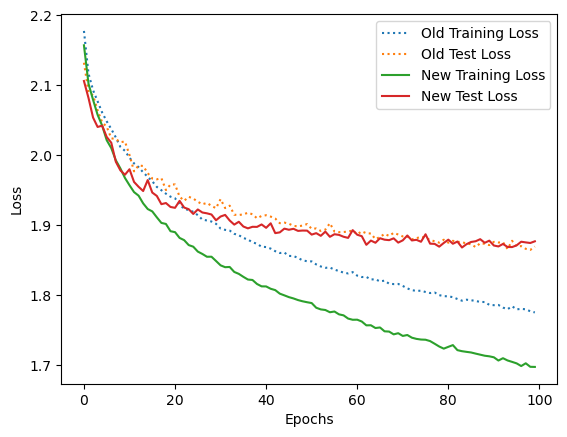

In [48]:
plt.plot(train_losses_2, label='Old Training Loss', linestyle=':')
plt.plot(test_losses_2, label='Old Test Loss', linestyle=':')
plt.plot(train_losses_3, label='New Training Loss')
plt.plot(test_losses_3, label='New Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

* Surprisingly, while the training losses have been improved in the larger model, the testing losses haven't, this shows that increasing the model size doesn't always affect its generalization ability.



## Save new model

In [49]:
vit_cp_path_new = "vit_new.pth"
torch.save(ViT_3.state_dict(), vit_cp_path_new)

## Comparison

In [50]:
ViT_3.eval()

VisionTransformer(
  (proj): Conv2d(3, 256, kernel_size=(8, 8), stride=(8, 8))
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (trans_blocks): ModuleList(
      (0-11): 12 x TransformerBlock(
        (attention): Attention(
          (wq): Linear(in_features=256, out_features=256, bias=False)
          (wk): Linear(in_features=256, out_features=256, bias=False)
          (wv): Linear(in_features=256, out_features=256, bias=False)
          (atten_dropout): Dropout(p=0.1, inplace=False)
          (proj_dropout): Dropout(p=0.1, inplace=False)
          (fc_out): Linear(in_features=256, out_features=256, bias=True)
        )
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (activation): GELU(approximate='none')
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_

In [51]:
pred_3, true_3 = infer(ViT_3, testloader)

### Accuracy

In [52]:
print(f"Old top-1 Accuracy on test set: {acc:.2f}%")
acc_3 = accuracy_score(true_3, pred_3) * 100
print(f"New top-1 Accuracy on test set: {acc_3:.2f}%")

Old top-1 Accuracy on test set: 52.59%
New top-1 Accuracy on test set: 58.21%


### Classification report

In [53]:
print("Old results:")
print(cr)

print("New results:")
print(classification_report(true_3, pred_3, target_names=img_classes))

Old results:
              precision    recall  f1-score   support

       plane       0.65      0.49      0.56      1000
         car       0.63      0.64      0.64      1000
        bird       0.41      0.41      0.41      1000
         cat       0.36      0.25      0.30      1000
        deer       0.46      0.51      0.49      1000
         dog       0.44      0.48      0.46      1000
        frog       0.52      0.65      0.58      1000
       horse       0.64      0.53      0.58      1000
        ship       0.58      0.71      0.64      1000
       truck       0.55      0.59      0.57      1000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.52     10000
weighted avg       0.53      0.53      0.52     10000

New results:
              precision    recall  f1-score   support

       plane       0.68      0.55      0.61      1000
         car       0.72      0.63      0.67      1000
        bird       0.48      0.51      0.49      100

### Confusion matrix

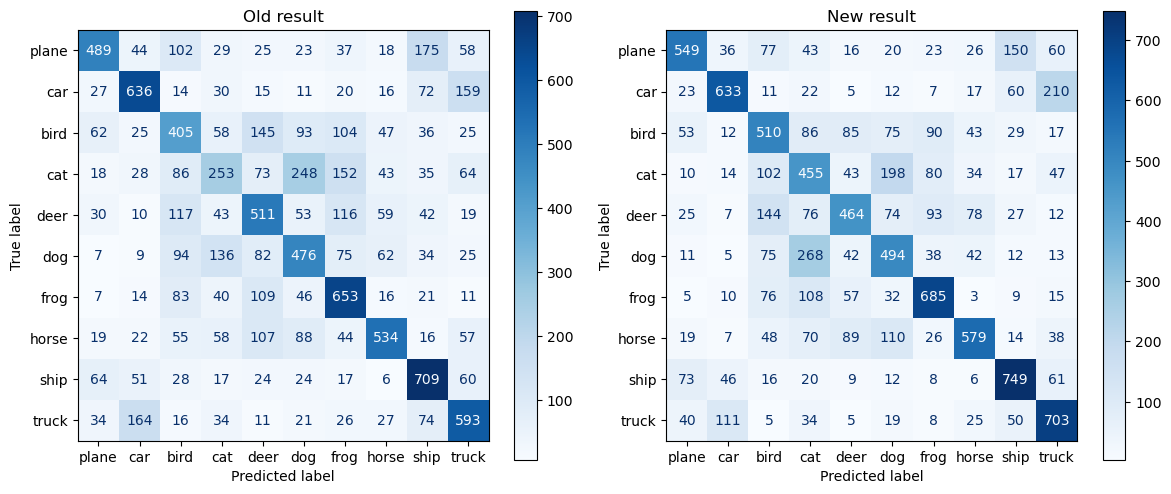

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

disp1 = ConfusionMatrixDisplay(cm, display_labels=img_classes)
disp1.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title('Old result')

new_cm = confusion_matrix(true_3, pred_3)
disp2 = ConfusionMatrixDisplay(new_cm, display_labels=img_classes)
disp2.plot(ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title('New result')

plt.tight_layout()
plt.show()

## Conclusion

* After some configurations, the model's performance has been improved significantly, although its predictions are still not perfect. Furthermore, it is evident that when training a Vision Transformer from scratch, its hyperparameters must be carefully tuned for each specific task or dataset.

* For CIFAR-10, the dataset is relatively small, thus somewhat affecting the model's generalization ability. Typically, Transformer models need to be pretrained on large, diverse datasets to achieve good results when fine-tuned on specific tasks.

## Reference

* Guide: PRACTICE #03: Vision Transformer - LQN, NMH

* https://github.com/kentaroy47/vision-transformers-cifar10/tree/main

* Alexey Dosovitskiy, Lucas Beyer, Alexander Kolesnikov, Dirk Weissenborn, Xiaohua Zhai, Thomas Unterthiner, Mostafa Dehghani, Matthias Minderer, Georg Heigold, Sylvain Gelly, Jakob Uszkoreit, & Neil Houlsby. (2021). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale. https://arxiv.org/abs/2010.11929